In [2]:
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')

In [3]:
from huggingface_hub import login
login(hf_token, add_to_git_credential=True)

In [4]:
!pip install datasets

In [5]:
from datasets import load_dataset

ds = load_dataset("hongrui/mimic_chest_xray_v_1")

In [6]:
!pip install  -U -q transformers trl datasets bitsandbytes peft accelerate

In [7]:
system_message = """You are an AI-powered diagnostic assistant trained to analyze medical images (e.g., X-rays, MRIs, CT scans, ultrasounds). Your purpose is to provide preliminary observations to aid healthcare professionals—not to replace clinical judgment."""

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


' The chest x-ray shows a large area of the lungs with a large area of opacity. The lung opacity is mostly in the right lung.'

In [9]:
shuffled_dataset = ds['train'].shuffle(seed=42)

# Select the first 500 samples for training
train_dataset = shuffled_dataset.select(range(500))

# Select the next 80 for validation
validation_dataset = shuffled_dataset.select(range(500, 580))

# Select the next 80 for testing
test_dataset = shuffled_dataset.select(range(580, 660))

# Create the final dataset dictionary
final_dataset = {
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
}

# Verify the sizes
print(f"Train samples: {len(final_dataset['train'])}")  # Should be 500
print(f"Validation samples: {len(final_dataset['validation'])}")  # Should be 80
print(f"Test samples: {len(final_dataset['test'])}")  # Should be 80

Train samples: 500
Validation samples: 80
Test samples: 80


In [10]:
train_dataset

Dataset({
    features: ['image', 'text', 'report'],
    num_rows: 500
})

In [11]:
train_dataset = [format_data(sample) for sample in train_dataset]
val_dataset = [format_data(sample) for sample in validation_dataset]
test_dataset = [format_data(sample) for sample in test_dataset]

In [12]:
train_dataset[:2]

[[{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an AI-powered diagnostic assistant trained to analyze medical images (e.g., X-rays, MRIs, CT scans, ultrasounds). Your purpose is to provide preliminary observations to aid healthcare professionals—not to replace clinical judgment.'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>},
    {'type': 'text',
     'text': "chest x-ray; 'Atelectasis'; 'Cardiomegaly'; 'Pleural Effusion'"}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'As compared to ___ chest radiograph, enlargement of the cardiac silhouette and distended pulmonary vessels are persistent finding, but there is no frank evidence of pulmonary edema. Moderate right pleural effusion is again demonstrated with adjacent right basilar atelectasis.'}]}],
 [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an AI-powered diagnostic 

In [13]:
from transformers import AutoTokenizer, AutoModelForImageTextToText

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolVLM2-256M-Video-Instruct")
model = AutoModelForImageTextToText.from_pretrained("HuggingFaceTB/SmolVLM2-256M-Video-Instruct")

In [14]:
!pip install num2words

In [15]:
from transformers import AutoProcessor, AutoModelForImageTextToText

model_id = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"

# Load processor (handles both images and text)
processor = AutoProcessor.from_pretrained(model_id)

In [72]:
train_dataset[1]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are an AI-powered diagnostic assistant trained to analyze medical images (e.g., X-rays, MRIs, CT scans, ultrasounds). Your purpose is to provide preliminary observations to aid healthcare professionals—not to replace clinical judgment.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>},
   {'type': 'text',
    'text': "chest x-ray; 'Lung Opacity'; 'Pleural Effusion'; 'Support Devices'"}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'Endotracheal tube is in standard position, and cardiomediastinal contours are stable. Airspace opacity of the opacities in the right mid and lower lung appear similar, but there is interval worsening of opacity in the left retrocardiac region, which may be due to an additional site of consolidation and/or atelectasis. Bilateral pleural effusions are unchanged as well as right apical pleu

In [17]:
train_dataset[1][1:2]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>},
   {'type': 'text',
    'text': "chest x-ray; 'Lung Opacity'; 'Pleural Effusion'; 'Support Devices'"}]}]

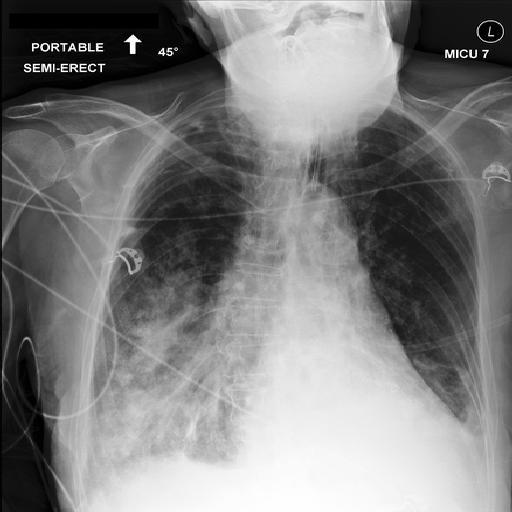

In [18]:
train_dataset[1][1]['content'][0]['image']

In [73]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[1:2],  # Use the sample without the system message
        add_generation_prompt=True
    )

    image_inputs = []
    image = sample[1]['content'][0]['image']
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image_inputs.append([image])

    # Prepare the inputs for the model
    model_inputs = processor(
        #text=[text_input],
        text=text_input,
        images=image_inputs,
        return_tensors="pt",
    ).to(device)  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

In [22]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)  # Move model to GPU


In [23]:
output = generate_text_from_sample(model, processor, train_dataset[1])


In [24]:
output

' The chest x-ray shows a clear lung image with no visible signs of pleural effusion or support devices. The lung image is clear and shows no signs of pleural effusion or support devices.'

In [25]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 0.01 GB
GPU reserved memory: 0.02 GB


In [87]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


In [88]:
from transformers import BitsAndBytesConfig
model_id = "HuggingFaceTB/SmolVLM2-256M-Video-Instruct"
model = AutoModelForImageTextToText.from_pretrained(
  "HuggingFaceTB/SmolVLM2-256M-Video-Instruct",
  quantization_config=bnb_config,
)
# Load processor (handles both images and text)
processor = AutoProcessor.from_pretrained(model_id)

In [89]:
model = model.to(device)  # Move model to GPU


In [90]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
    use_dora=True,
    init_lora_weights="gaussian"
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 3,067,776 || all params: 259,552,704 || trainable%: 1.1819


In [91]:
from trl import SFTConfig

# Configure training arguments using SFTConfig
training_args = SFTConfig(
    output_dir="smolvlm-instruct-trl-sft-ChartQA",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=25,
    save_total_limit=1,
    optim="adamw_torch_fused",
    report_to="none",
    remove_unused_columns=False,
    gradient_checkpointing=True,
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
)

In [40]:
processor.tokenizer

GPT2TokenizerFast(name_or_path='HuggingFaceTB/SmolVLM2-256M-Video-Instruct', vocab_size=49152, model_max_length=8192, is_fast=True, padding_side='right', truncation_side='left', special_tokens={'bos_token': '<|im_start|>', 'eos_token': '<end_of_utterance>', 'unk_token': '<|endoftext|>', 'pad_token': '<|im_end|>', 'additional_special_tokens': ['<fake_token_around_image>', '<image>', '<end_of_utterance>'], 'end_of_utterance_token': '<end_of_utterance>', 'fake_image_token': '<fake_token_around_image>', 'global_image_token': '<global-img>', 'image_token': '<image>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<repo_name>", rstrip=Fa

In [93]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
    texts = [processor.apply_chat_template(example, tokenize=False) for example in examples]

    image_inputs = []
    for example in examples:
      image = example[1]['content'][0]['image']
      if image.mode != 'RGB':
          image = image.convert('RGB')
      image_inputs.append([image])

    batch = processor(text=texts, images=image_inputs, return_tensors="pt", padding=True)
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels
    labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels

    return batch

In [94]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,  # Your custom collator
    peft_config=peft_config,
)

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [81]:
train_dataset[1]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are an AI-powered diagnostic assistant trained to analyze medical images (e.g., X-rays, MRIs, CT scans, ultrasounds). Your purpose is to provide preliminary observations to aid healthcare professionals—not to replace clinical judgment.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>},
   {'type': 'text',
    'text': "chest x-ray; 'Lung Opacity'; 'Pleural Effusion'; 'Support Devices'"}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'Endotracheal tube is in standard position, and cardiomediastinal contours are stable. Airspace opacity of the opacities in the right mid and lower lung appear similar, but there is interval worsening of opacity in the left retrocardiac region, which may be due to an additional site of consolidation and/or atelectasis. Bilateral pleural effusions are unchanged as well as right apical pleu

In [95]:
trainer.train()

Step,Training Loss
25,3.394200


TrainOutput(global_step=31, training_loss=3.235561893832299, metrics={'train_runtime': 3364.5912, 'train_samples_per_second': 0.149, 'train_steps_per_second': 0.009, 'total_flos': 906431248452096.0, 'train_loss': 3.235561893832299})

In [97]:
trainer.save_model(training_args.output_dir)

In [98]:
training_args.output_dir

'smolvlm-instruct-trl-sft-ChartQA'

In [99]:
!zip -r model.zip {training_args.output_dir}

  adding: smolvlm-instruct-trl-sft-ChartQA/ (stored 0%)
  adding: smolvlm-instruct-trl-sft-ChartQA/runs/ (stored 0%)
  adding: smolvlm-instruct-trl-sft-ChartQA/runs/Apr26_23-27-19_78d68445152c/ (stored 0%)
  adding: smolvlm-instruct-trl-sft-ChartQA/runs/Apr26_23-27-19_78d68445152c/events.out.tfevents.1745710060.78d68445152c.9170.0 (deflated 67%)
  adding: smolvlm-instruct-trl-sft-ChartQA/runs/Apr26_23-33-10_78d68445152c/ (stored 0%)
  adding: smolvlm-instruct-trl-sft-ChartQA/runs/Apr26_23-33-10_78d68445152c/events.out.tfevents.1745710397.78d68445152c.9170.1 (deflated 67%)
  adding: smolvlm-instruct-trl-sft-ChartQA/special_tokens_map.json (deflated 75%)
  adding: smolvlm-instruct-trl-sft-ChartQA/tokenizer_config.json (deflated 94%)
  adding: smolvlm-instruct-trl-sft-ChartQA/README.md (deflated 66%)
  adding: smolvlm-instruct-trl-sft-ChartQA/checkpoint-31/ (stored 0%)
  adding: smolvlm-instruct-trl-sft-ChartQA/checkpoint-31/special_tokens_map.json (deflated 75%)
  adding: smolvlm-instruc